In [1]:
#Load all required libraries
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
import joblib
import pickle
from sklearn.linear_model import LogisticRegression



In [2]:
#Read the file
df = pd.read_csv("diabetes.csv")

In [3]:
#Here we are checking for duplicated values, and we have non
df.duplicated().sum()

0

In [4]:
#we did this to have an identifier for our datapoints so we can later use it for Quality Assurance
df.reset_index(inplace=True)

Beginning of data preparation & cleaning
- Dealing with Outliers
- Performing Normalization to the selected feauters
- Dealing with NA values
- Dealing with data types

In [5]:
df.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33.6,0.627,50,1
1,1,1,85,66,29,0,26.6,0.351,31,0
2,2,8,183,64,0,0,23.3,0.672,32,1
3,3,1,89,66,23,94,28.1,0.167,21,0
4,4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     768 non-null    int64  
 1   Pregnancies               768 non-null    int64  
 2   Glucose                   768 non-null    int64  
 3   BloodPressure             768 non-null    int64  
 4   SkinThickness             768 non-null    int64  
 5   Insulin                   768 non-null    int64  
 6   BMI                       768 non-null    float64
 7   DiabetesPedigreeFunction  768 non-null    float64
 8   Age                       768 non-null    int64  
 9   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 60.1 KB


In [7]:
#correlation of dataset
corr_data= df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']].corr()
corr_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [8]:
 #Checking missing values
df.isna().sum()

index                       0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

##
We will write here some reserach that justify why we are including the outliers
##

In [9]:
# Count the number of outliers for each variable
outlier_counts = {
    "Pregnancies": ((df["Pregnancies"] < 0) | (df["Pregnancies"] > 15)).sum(),
    "Glucose": ((df["Glucose"] < 40) | (df["Glucose"] > 600)).sum(),
    "BloodPressure": ((df["BloodPressure"] < 30) | (df["BloodPressure"] > 200)).sum(),
    "SkinThickness": ((df["SkinThickness"] < 0) | (df["SkinThickness"] > 100)).sum(),
    "Insulin": ((df["Insulin"] <0) | (df["Insulin"] > 300)).sum(),
    "BMI": ((df["BMI"] < 12) | (df["BMI"] > 100)).sum(),
    "Age": ((df["Age"] < 0) | (df["Age"] > 100)).sum()
}

# Convert to DataFrame for better visualization
outlier_summary = pd.DataFrame(list(outlier_counts.items()), columns=["Variable", "Outlier Count"])
outlier_summary


,Variable,Outlier Count
0,Pregnancies,1
1,Glucose,5
2,BloodPressure,36
3,SkinThickness,0
4,Insulin,37
5,BMI,11
6,Age,0


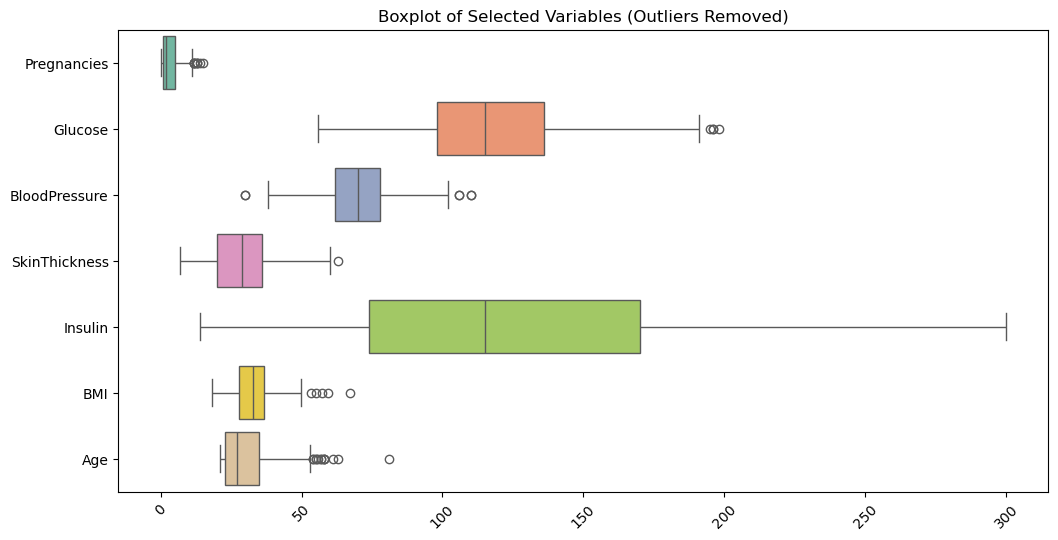

In [10]:


# Define valid ranges based on your criteria
valid_ranges = {
    "Pregnancies": (0, 15),
    "Glucose": (40, 600),
    "BloodPressure": (30, 200),
    "SkinThickness": (5, 100),
    "Insulin": (2, 300),
    "BMI": (12, 100),
    "Age": (0, 100),
}

# Create a copy of the dataset for filtering
df_filtered = df.copy()

# Remove outliers based on the given thresholds
for col, (low, high) in valid_ranges.items():
    df_filtered = df_filtered[(df_filtered[col] >= low) & (df_filtered[col] <= high)]

# Select only the relevant columns for plotting
columns_to_plot = list(valid_ranges.keys())

# Plot boxplots with only the selected columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered[columns_to_plot], orient="h", palette="Set2")
plt.xticks(rotation=45)
plt.title("Boxplot of Selected Variables (Outliers Removed)")
plt.show()


In [11]:
# correlation of all columns with  target 'Outcome'
medv_corr = df.corr()['Outcome']

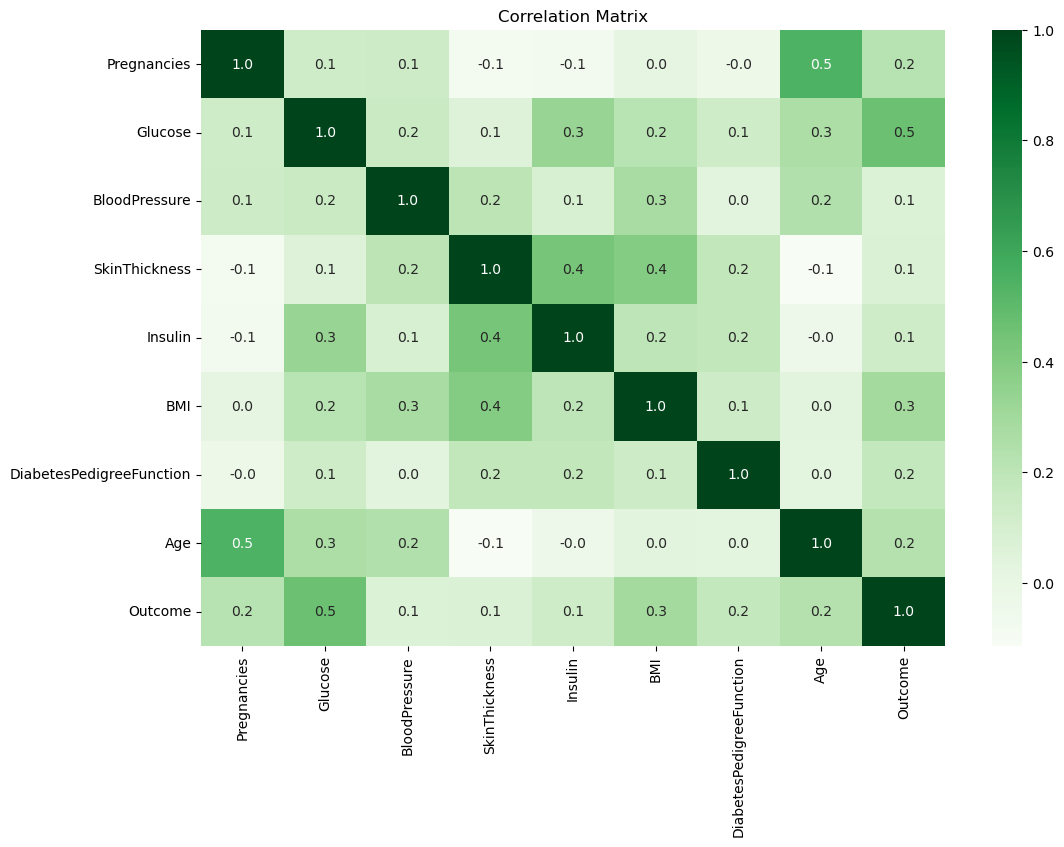

In [12]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_data, annot=True, cmap='Greens', fmt='.1f')
plt.title('Correlation Matrix')
plt.show()

In [13]:
df.columns

Index(['index', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [14]:
# This won't be important because we want to retain our model in a loop with different seeds,
# and with each iteration, we will be splitting, noramlizing, and then train our model.
# Define features and target
X = df.drop(columns=["Outcome","index"])
y = df["Outcome"]


In [15]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [16]:
#making sure that the selected target only have 1 or 0 valeus
df['Outcome'].unique()

array([1, 0], dtype=int64)

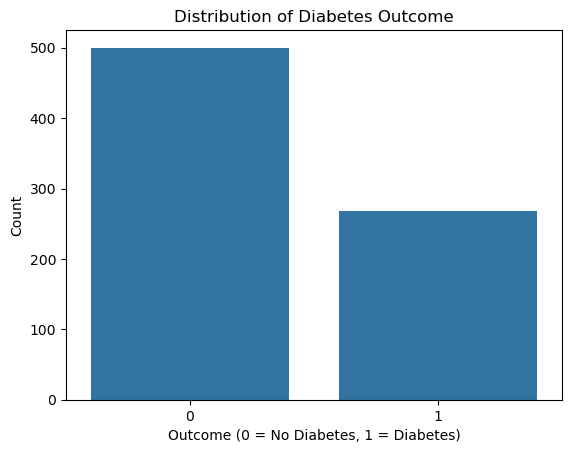

In [17]:
#visulaize the outcome data making sure we don't have biased data set
#This shows that we have almost double the data with no diabes in comparison to people with diabetes

sns.barplot(x=df['Outcome'].value_counts().index,
            y=df['Outcome'].value_counts().values)
plt.xlabel("Outcome (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Count")
plt.title("Distribution of Diabetes Outcome")
plt.show()

In this section we are doing the following in a pythonic way:
- Split the data within the model because we are going to have different splits with different seeds
- Select the seeds that will produce better performance
- Compare three main reading for our model accuracy performance (testing data, training data, overall data)
- After compelting that, we are revisiting our feauters using GridSearch and decide what to do with less important feauters
- Retrain the model with new selected feauters and compare overall performance


Here we are using importance to detect what feauters out of the selected ones are important and what are not

In this section we are applying cross validation, and for both scenarios our cross-validation accuracy rate was below the original. what is the best practice here?

Because we see that the RandomClassifier had the best performance we will save it and use it for prediction

In [18]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In this section, we are trying to implement LogisticRegression classifier and trying to experiement with different train/test splits and compare the outcomes to average of cross validation (bigger varriance = less reliable model)

In [19]:
Highest_Accuracy = 0
Best_Seed = 0

# List of seeds to explore
seeds = [90, 95, 100, 242, 1500, 1001, 2023, 2000, 2003, 102, 2001, 2006]

# Features to normalize
columns_to_scale = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

for seed in seeds:
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Initialize and fit the scaler on X_train only
    scaler = MinMaxScaler()
    scaler.fit(X_train[columns_to_scale])

    # Transform X_train and X_test using the fitted scaler
    X_train_scaled = X_train  # Avoid modifying the original DataFrame
    X_test_scaled = X_test

    X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    # Train the Logistic Regression model
    LogisticRegressionmodel = LogisticRegression(random_state=seed)
    LogisticRegressionmodel.fit(X_train_scaled, y_train)

    # Make predictions on the correctly normalized X_test
    y_pred = LogisticRegressionmodel.predict(X_test_scaled)
    current_accuracy = accuracy_score(y_test, y_pred)

    # Store the best-performing model
    if current_accuracy > Highest_Accuracy:
        Best_Model = LogisticRegression(random_state=seed)
        Highest_Accuracy = current_accuracy
        Best_Seed = seed
        Best_y_pred = y_pred
        Best_y_test = y_test
      

# Print the best model accuracy and classification report
print(f'Highest Accuracy was with seed {Best_Seed}\nAccuracy Rate = {Highest_Accuracy}')
print(classification_report(Best_y_test, Best_y_pred, target_names=['Non Diabetic', 'Diabetic']))


Highest Accuracy was with seed 1001
Accuracy Rate = 0.8376623376623377
              precision    recall  f1-score   support

Non Diabetic       0.82      0.96      0.89       101
    Diabetic       0.89      0.60      0.72        53

    accuracy                           0.84       154
   macro avg       0.86      0.78      0.80       154
weighted avg       0.85      0.84      0.83       154



In [20]:
Highest_Accuracy = 0
Best_Seed = 0
Best_Params = {}

# List of seeds to explore
seeds = [90, 95, 100, 242, 1500, 1001, 2023, 2000, 2003, 102, 2001, 2006]

# Features to normalize
columns_to_scale = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 50, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # L1 (Lasso) and L2 (Ridge)
    'solver': ['liblinear']  # Required solver for L1/L2 regularization
}

for seed in seeds:
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Initialize and fit the scaler on X_train only
    scaler = MinMaxScaler()
    scaler.fit(X_train[columns_to_scale])

    # Transform X_train and X_test using the fitted scaler
    X_train_scaled = X_train.copy()  # Avoid modifying the original DataFrame
    X_test_scaled = X_test.copy()

    X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(LogisticRegression(random_state=seed), param_grid, cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Make predictions on the correctly normalized X_test
    y_pred = best_model.predict(X_test_scaled)
    current_accuracy = accuracy_score(y_test, y_pred)

    # Store the best-performing model
    if current_accuracy > Highest_Accuracy:
        Best_Model = best_model
        Highest_Accuracy = current_accuracy
        Best_Seed = seed
        Best_y_pred = y_pred
        Best_y_test = y_test
        Best_Params = grid_search.best_params_
        Best_x_test = X_test.copy()
        best_scaler = scaler

# Print the best model accuracy and classification report
print(f'Highest Accuracy was with seed {Best_Seed}\nAccuracy Rate = {Highest_Accuracy}')
print(f'Best Hyperparameters: {Best_Params}')
print(classification_report(Best_y_test, Best_y_pred, target_names=['Non Diabetic', 'Diabetic']))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Highest Accuracy was with seed 1001
Accuracy Rate = 0.8246753246753247
Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

Non Diabetic       0.81      0.95      0.88       101
    Diabetic     

✅ Conclusion: The model does well at identifying people who are not diabetic.


⚠️ Risk: The recall for diabetics is only 58%, meaning 42% of actual diabetic patients go undetected.



In [21]:
#looking at the performance of the model with training data
y_pred_train = Best_Model.predict(X_train_scaled)
current_accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy Rate = {current_accuracy_train}')
print(classification_report(y_train, y_pred_train, target_names=['Non Diabetic', 'Diabetic']))

Accuracy Rate = 0.7817589576547231
              precision    recall  f1-score   support

Non Diabetic       0.78      0.92      0.85       403
    Diabetic       0.78      0.51      0.62       211

    accuracy                           0.78       614
   macro avg       0.78      0.72      0.73       614
weighted avg       0.78      0.78      0.77       614



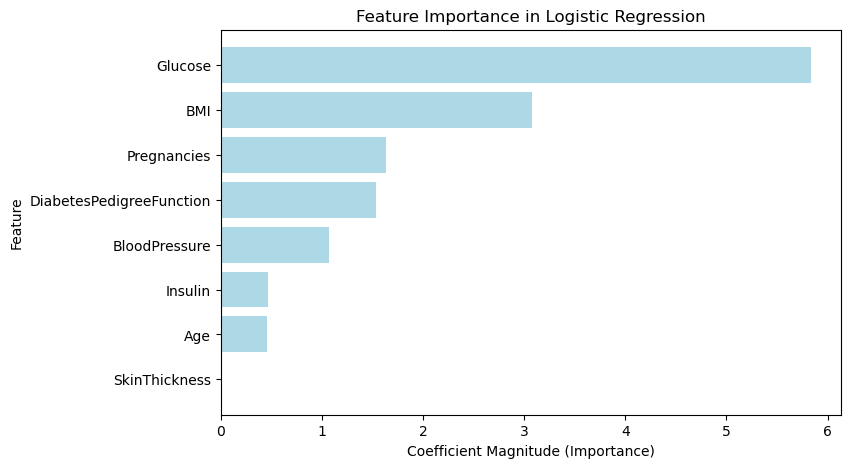

                    Feature  Importance
1                   Glucose    5.837115
5                       BMI    3.077003
0               Pregnancies    1.633095
6  DiabetesPedigreeFunction    1.537925
2             BloodPressure    1.073099
4                   Insulin    0.471948
7                       Age    0.453613
3             SkinThickness    0.000000


In [22]:
feature_importance = np.abs(Best_Model.coef_[0])

importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="lightblue")
plt.xlabel("Coefficient Magnitude (Importance)")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression")
plt.gca().invert_yaxis()
plt.show()


print(importance_df)

In [23]:
# Save the model and save the scaler
joblib.dump(Best_Model, 'LineraRegressionClassifier_v2.pkl')
pickle.dump(scaler, open("scaler.pkl", "wb"))

In [24]:

X_test_df = pd.DataFrame(Best_x_test)
y_test_df = pd.DataFrame(Best_y_test)
y_pred_df = pd.DataFrame(Best_y_pred, columns=['Predicted_Outcome'])
X_test_df.reset_index(inplace=True)
y_test_df.reset_index(inplace=True)
y_pred_df.reset_index(inplace=True)

results_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

results_df.to_excel("model_test_results_raw.xlsx", index=False)

print("✅ X_test, y_test, and y_pred have been saved to 'model_test_results.xlsx'")




✅ X_test, y_test, and y_pred have been saved to 'model_test_results.xlsx'


In [25]:
#Testing with StandarScale() to see if it will make any different
Highest_Accuracy = 0
Best_Seed = 0

# List of seeds to explore
seeds = [90, 95, 100, 242, 1500, 1001, 2023, 2000, 2003, 102, 2001, 2006]

# Features to normalize
columns_to_scale = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

for seed in seeds:
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Initialize and fit the scaler on X_train only
    scaler = StandardScaler()
    scaler.fit(X_train[columns_to_scale])

    # Transform X_train and X_test using the fitted scaler
    X_train_scaled = X_train  # Avoid modifying the original DataFrame
    X_test_scaled = X_test

    X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    # Train the Logistic Regression model
    LogisticRegressionmodel = LogisticRegression(random_state=seed)
    LogisticRegressionmodel.fit(X_train_scaled, y_train)

    # Make predictions on the correctly normalized X_test
    y_pred = LogisticRegressionmodel.predict(X_test_scaled)
    current_accuracy = accuracy_score(y_test, y_pred)

    # Store the best-performing model
    if current_accuracy > Highest_Accuracy:
        Best_Model = LogisticRegression(random_state=seed)
        #Best_Model.fit(X_train_scaled, y_train)  # Train it immediately inside the loop, if we want to train it inside the loop
        Highest_Accuracy = current_accuracy
        Best_Seed = seed
        Best_y_pred = y_pred
        Best_y_test = y_test

# Print the best model accuracy and classification report
print(f'Highest Accuracy was with seed {Best_Seed}\nAccuracy Rate = {Highest_Accuracy}')
print(classification_report(Best_y_test, Best_y_pred, target_names=['Non Diabetic', 'Diabetic']))


Highest Accuracy was with seed 1001
Accuracy Rate = 0.8246753246753247
              precision    recall  f1-score   support

Non Diabetic       0.82      0.93      0.87       101
    Diabetic       0.82      0.62      0.71        53

    accuracy                           0.82       154
   macro avg       0.82      0.78      0.79       154
weighted avg       0.82      0.82      0.82       154



In [26]:
#testing the model with 30% test size

Highest_Accuracy = 0
Best_Seed = 0

# List of seeds to explore
seeds = [90, 95, 100, 242, 1500, 1001, 2023, 2000, 2003, 102, 2001, 2006]

# Features to normalize
columns_to_scale = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

for seed in seeds:
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Initialize and fit the scaler on X_train only
    scaler = MinMaxScaler()
    scaler.fit(X_train[columns_to_scale])

    # Transform X_train and X_test using the fitted scaler
    X_train_scaled = X_train  # Avoid modifying the original DataFrame
    X_test_scaled = X_test

    X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    # Train the Logistic Regression model
    LogisticRegressionmodel = LogisticRegression(random_state=seed)
    LogisticRegressionmodel.fit(X_train_scaled, y_train)

    # Make predictions on the correctly normalized X_test
    y_pred = LogisticRegressionmodel.predict(X_test_scaled)
    current_accuracy = accuracy_score(y_test, y_pred)

    # Store the best-performing model
    if current_accuracy > Highest_Accuracy:
        Best_Model = LogisticRegression(random_state=seed)
        #Best_Model.fit(X_train_scaled, y_train)  # Train it immediately inside the loop, if we want to train it inside the loop
        Highest_Accuracy = current_accuracy
        Best_Seed = seed
        Best_y_pred = y_pred
        Best_y_test = y_test

# Print the best model accuracy and classification report
print(f'Highest Accuracy was with seed {Best_Seed}\nAccuracy Rate = {Highest_Accuracy}')
print(classification_report(Best_y_test, Best_y_pred, target_names=['Non Diabetic', 'Diabetic']))


Highest Accuracy was with seed 242
Accuracy Rate = 0.8138528138528138
              precision    recall  f1-score   support

Non Diabetic       0.83      0.93      0.88       167
    Diabetic       0.73      0.52      0.61        64

    accuracy                           0.81       231
   macro avg       0.78      0.72      0.74       231
weighted avg       0.81      0.81      0.80       231

